In [1]:
# Imports and declarations
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["image.cmap"] = "binary_r"
sys.path.append("../../semi-supervised")

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
cuda = torch.cuda.is_available()

# Auxiliary Deep Generative Model

In this notebook we will run the Auxiliary Deep Generative Model as described in (Maaløe 2016). The model is similar to the Deep Generative Model described in (Kingma 2014), with the addition of an auxiliary variable $a$. The idea is that introducing another latent variable that is marginalised out will allow the autoencoder to learn more complicated distributions and will be able to seperate the latent factors with higher precision.

In the MNIST case, we can represent the variables as:

* $y$: the label of the digit
* $a$: the style of the digit

In [2]:
from data.limitedmnist import LimitedMNIST
from utils import generate_label, onehot

batch_size = 64

labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n = len(labels)

# Load in data
mnist_lab = LimitedMNIST('./', train=True, transform=torch.bernoulli, target_transform=onehot(n), digits=labels, fraction=0.005)
mnist_ulab = LimitedMNIST('./', train=True, transform=torch.bernoulli, target_transform=onehot(n), digits=labels, fraction=1.0)
mnist_val = LimitedMNIST('./', train=False, transform=torch.bernoulli, target_transform=onehot(n), digits=labels)

# Unlabelled data
unlabelled = torch.utils.data.DataLoader(mnist_ulab, batch_size=batch_size, shuffle=True, num_workers=2)

# Validation data
validation = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=True, num_workers=2)

# Labelled data
labelled = torch.utils.data.DataLoader(mnist_lab, batch_size=batch_size, shuffle=True, num_workers=2)

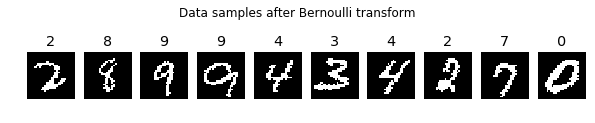

In [3]:
f, axarr = plt.subplots(1, 10, figsize=(10, 2))
images, labels = next(iter(labelled))
_, labels = torch.max(labels, 1)

for i in range(10):
    axarr[i].imshow(images[i].numpy().reshape(28, 28))
    title = labels[i]# if labels[i] < 5 else "Unknown"
    axarr[i].set_title(title)
    axarr[i].axis("off")
    
f.suptitle("Data samples after Bernoulli transform")
plt.show()

Again `VariationalInferenceWithLabels` is used to model the objective, shown below:


\begin{align}
\log p(x, y) &\geq \mathbb{E}_{q_{\phi}(a, z|x, y)} [ \log p_{\theta}(x, y, a, z) - \log q_{\phi}(a, y, z|x) ]\\
&= \mathbb{E}_{q_{\phi}(a, z|x, y)} [ \log p_{\theta}(x, y, a, z) - \log q_{\phi}(a | x) -  \log q_{\phi}(z | a, y, x) ] = - \mathcal{L}(x, y)
\end{align}

In [4]:
from models import AuxiliaryDeepGenerativeModel
from inference.loss import VariationalInferenceWithLabels, kl_divergence_normal, discrete_uniform_prior

# Numerical stability
epsilon = 1e-7

# ADGM with a single hidden layer in both the encoder and decoder
model = AuxiliaryDeepGenerativeModel(ratio=len(mnist_ulab)/len(mnist_lab), dims=[28 * 28, n, 16, [128, 64]])

if cuda: model.cuda()

def binary_cross_entropy(r, x):
    return torch.sum((x * torch.log(r + epsilon) + (1 - x) * torch.log((1 - r) + epsilon)), dim=-1)

def cross_entropy(y, logits):
    return -torch.sum(y * torch.log(logits + epsilon), dim=1)
    
objective = VariationalInferenceWithLabels(binary_cross_entropy, kl_divergence_normal, discrete_uniform_prior)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model

AuxiliaryDeepGenerativeModel (
  (encoder): Encoder (
    (hidden): ModuleList (
      (0): Linear (16 -> 128)
      (1): Linear (128 -> 64)
    )
    (sample): StochasticGaussian (
      (mu): Linear (64 -> 16)
      (log_var): Linear (64 -> 16)
    )
  )
  (decoder): Decoder (
    (hidden): ModuleList (
      (0): Linear (16 -> 64)
      (1): Linear (64 -> 128)
    )
    (reconstruction): Linear (128 -> 784)
    (output_activation): Sigmoid ()
  )
  (aux_encoder): Encoder (
    (hidden): ModuleList (
      (0): Linear (784 -> 128)
      (1): Linear (128 -> 64)
    )
    (sample): StochasticGaussian (
      (mu): Linear (64 -> 16)
      (log_var): Linear (64 -> 16)
    )
  )
  (aux_decoder): Decoder (
    (hidden): ModuleList (
      (0): Linear (16 -> 64)
      (1): Linear (64 -> 128)
    )
    (reconstruction): Linear (128 -> 16)
    (output_activation): Sigmoid ()
  )
  (classifier): Classifier (
    (dense): Linear (784 -> 128)
    (logits): Linear (128 -> 10)
  )
  (transform_x_t

Something about unlabelled lower bound.

In [5]:
class DGMTrainer():
    """
    Class for training Deep Generative Models.
    :param model: Object of class `DeepGenerativeModel`
    :param objective: Loss function for labelled data, e.g. `VariationalInferenceWithLabels`
    :param optimizer: A PyTorch-enabled optimizer
    :param cuda: Optional parameter whether to use CUDA acceleration
    """
    def __init__(self, model, objective, optimizer, cuda=False):
        self.model = model
        self.objective = objective
        self.optimizer = optimizer
        self.cuda = cuda

    def calculate_loss(self, x, y=None):
        """
        Given a semi-supervised problem (x, y) pair where y
        is only occasionally observed, calculates the
        associated loss.
        :param x: Features
        :param y: Labels (optional)
        :returns L_alpha if labelled, U if unlabelled.
        """
        is_unlabelled = True if y is None else False

        x = Variable(x)
        logits = self.model(x)

        # If the data is unlabelled, sum over all classes
        if is_unlabelled:
            [batch_size, *_] = x.size()
            x = x.repeat(n, 1)
            y = torch.cat([generate_label(batch_size, i, n) for i in range(n)])

        y = Variable(y.type(torch.FloatTensor))
        
        if self.cuda:
            x = x.cuda()
            y = y.cuda()

        # Compute lower bound (the same as -L)
        reconstruction, _, z, a = self.model(x, y)
        ELBO = self.objective(reconstruction, x, y, [z, a])

        # In the unlabelled case calculate the entropy H and return U
        if is_unlabelled:
            ELBO = ELBO.view(logits.size())
            loss = torch.sum(torch.mul(logits, ELBO - torch.log(logits)), -1)
            loss = -torch.mean(loss)
        # In the case of labels add cross entropy and return L_alpha
        else:
            loss = ELBO + self.model.beta * -cross_entropy(y, logits)
            loss = -torch.mean(loss)

        return loss
    
    def train(self, labelled, unlabelled):
        """
        Trains a DGM model based on some data.
        :param labelled: Labelled data loader
        :param inlabelled: Unlabelled data loader
        :return L, U: Final loss values.
        """
        for (x, y), (u, _) in zip(labelled, unlabelled):
            L = self.calculate_loss(x, y)
            U = self.calculate_loss(u, None)

            J = L + U

            J.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
        return L, U

## Visualisation

Here you can optionally enable the use of `visdom` to visualise the training process.

In [6]:
use_visdom = True

if use_visdom:
    import visdom
    vis = visdom.Visdom()

class Visualiser():
    def __init__(self):
        self.loss = vis.line(X=np.array([0]), Y=np.array([0]), opts=dict(title="Training Loss", xlabel="Epoch"))
        self.acc  = vis.line(X=np.array([0]), Y=np.array([0]), opts=dict(title="Accuracy", xlabel="Epoch"))

    def update_loss(self, L, U):
        vis.updateTrace(X=np.array([epoch]), Y=L.data.numpy(), win=self.loss, name="Labelled")
        vis.updateTrace(X=np.array([epoch]), Y=U.data.numpy(), win=self.loss, name="Unlabelled")
        
    def update_accuracy(self, model):
        accuracy = []
        for x, y in validation:
            _, prediction = torch.max(model(Variable(x)), 1)
            _, y = torch.max(y, 1)

            accuracy += [torch.mean((prediction.data == y).float())]

        vis.updateTrace(X=np.array([epoch]), Y=np.array([np.mean(accuracy)]), win=self.acc)
        
    def update_images(self, model):
        x, y = next(iter(validation))
        input = Variable(x[:5])
        label = Variable(y[:5].type(torch.FloatTensor))
        x_hat, *_ = model(input, label)
        images = x_hat.data.numpy().reshape(-1, 1, 28, 28)

        vis.images(images, opts=dict(width=5*64, height=64, caption="Sample epoch {}".format(epoch)))

Controlling which dataloaders to use, we gather the losses into a single combined loss that we can backpropagate.

$$\mathcal{J}^{\alpha} = \mathcal{L}^{\alpha} + \mathcal{U}$$

In [7]:
from torch.autograd import Variable

trainer = DGMTrainer(model, objective, optimizer)
visual = Visualiser()

for epoch in range(1001):
    L, U = trainer.train(labelled, unlabelled)
        
    if use_visdom:
        # Plot the last L and U of the epoch
        visual.update_loss(L, U)
        visual.update_accuracy(model)

        if epoch % 50 == 0:
            visual.update_images(model)

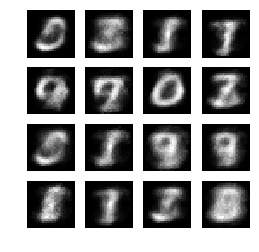

In [8]:
z = Variable(torch.randn(16, 16))
a = Variable(torch.randn(16, 16))
y = Variable(generate_label(16, 0, 10))

x = model.sample(z, a, y)

images = x.view(-1, 28, 28).data.numpy()

f, axarr = plt.subplots(4, 4, figsize=(4, 4))

for i in range(16):
    axarr[i%4, i//4].imshow(images[i])
    axarr[i%4, i//4].axis("off")